In [1]:
import os
import sys
import shutil
import numpy as np
import torch
import utils
import vis_utils_layout as vis_utils
from data_layout import LayoutDataset, Tree
import model_layout as model
import tqdm

sys.setrecursionlimit(5000) 

num_gen = 300
num_recon = 200
exp = 'publay-1W'
category = 'publaynet'
checkpoint = '212_'
device = 'cuda:0'

path = '/home/weiran/Projects/RvNN-Layout/GT-Layout/' + category + '/logs/' + exp
data_path = '/home/weiran/Projects/RvNN-Layout/data/' + category + '-ours/' + exp

# load train config
conf = torch.load(path + '/conf.pth')

# load object category information
Tree.load_category_info(conf.category)

# set up device
print(f'Using device: {conf.device}')

recon_dir = path + '/recon-test/'
gen_dir = path + '/generation/'

# if os.path.exists(recon_dir):
#     shutil.rmtree(recon_dir)
# os.mkdir(recon_dir)

# if os.path.exists(gen_dir):
#     shutil.rmtree(gen_dir)
# os.mkdir(gen_dir)

# create models
# we disable probabilistic because we do not need to jitter the decoded z during inference
encoder = model.RecursiveEncoder(conf, variational=True, probabilistic=False)
decoder = model.RecursiveDecoder(conf)

# load the pretrained models
print('Loading ckpt pretrained_encoder.pth')
data_to_restore = torch.load(path + '/ckpts/' + checkpoint + 'net_encoder.pth')
encoder.load_state_dict(data_to_restore, strict=True)
print('DONE\n')
print('Loading ckpt pretrained_decoder.pth')
data_to_restore = torch.load(path + '/ckpts/' + checkpoint + 'net_decoder.pth')
decoder.load_state_dict(data_to_restore, strict=True)
print('DONE\n')

# send to device
encoder.to(device)
decoder.to(device)

# set models to evaluation mode
encoder.eval()
decoder.eval()

# read test.txt
with open(data_path + '/test.txt', 'r') as fin:
    data_list = [l.rstrip() for l in fin.readlines()]

Using device: cuda:1
Loading ckpt pretrained_encoder.pth
DONE

Loading ckpt pretrained_decoder.pth
DONE



In [2]:
code = torch.randn(1, conf.feature_size).to(device)

In [3]:
# infer through the model to get the generated hierarchy
# set maximal tree depth to conf.max_tree_depth
obj_arr = decoder.decode_structure(z=code, max_depth=conf.max_tree_depth)

obj_arr.get_arrbox()

print(str(obj_arr))

# output the assembled box-shape
vis_utils.draw_partnet_objects([obj_arr],\
        object_names=['GENERATION'], \
        figsize=(5, 5), leafs_only=True, sem_colors_filename='./part_colors_magazine.txt')

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
def arr_v(node):
    total = 0.0
    if node.children is not None:
        for child in node.children:
            total += child.box[0,1] + child.box[0,3]
        for child in node.children:
            child.box[0,1] /= total
            child.box[0,3] /= total
        for index, child in enumerate(node.children):
            if index != 0 and child.box[0,1] < 0.02:
                child.box[0,3] -= 0.02 - child.box[0,0]
                child.box[0,1] = 0.02

def arr_h(node):
    total = 0.0
    if node.children is not None:
        for child in node.children:
            total += child.box[0,0] + child.box[0,2]
        for child in node.children:
            child.box[0,0] /= total
            child.box[0,2] /= total
        for index, child in enumerate(node.children):
            if index != 0 and child.box[0,0] < 0.02:
                child.box[0,2] -= 0.02 - child.box[0,0]
                child.box[0,0] = 0.02
            

def arr_s(node):
    if node.children is not None:
        for child in node.children:
            total_h = 0.0
            total_v = 0.0
            total_h += child.box[0,0] + child.box[0,2]
            total_v += child.box[0,1] + child.box[0,3]
            
            child.box[0,0] /= total_h
            child.box[0,2] /= total_h
            child.box[0,1] /= total_v
            child.box[0,3] /= total_v

def arr_layout(node):
    if node.children is not None:
        if node.label == 'vertical_branch':
            arr_v(node)
        elif node.label == 'horizontal_branch':
            arr_h(node)
        elif node.label == 'stack_branch':
            arr_s(node)
        for index, child in enumerate(node.children):
            # if child.box[0,2] + child.box[0,0] > 0.9:
            #     child.box[0,2] = 1.0
            #     child.box[0,0] = 0.0
            # if child.box[0,3] + child.box[0,1] > 0.9:
            #     child.box[0,3] = 1.0
            #     child.box[0,1] = 0.0
                
            if child.box[0,2]  > 0.95:
                child.box[0,2] = 1.0
                child.box[0,0] = 0.0
            if child.box[0,3] > 0.95:
                child.box[0,3] = 1.0
                child.box[0,1] = 0.0
            arr_layout(child)

# test_obj = obj_arr
# arr_layout(test_obj.root)

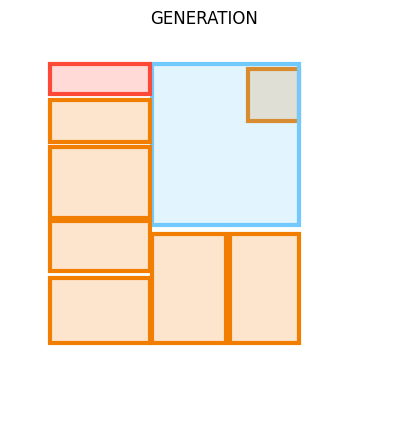

In [ ]:
test_obj.get_arrbox()

# output the assembled box-shape
vis_utils.draw_partnet_objects([test_obj],\
        object_names=['GENERATION'], \
        figsize=(5, 5), leafs_only=True, sem_colors_filename='./part_colors_magazine.txt')

In [45]:
code = torch.randn(1, conf.feature_size).to(device)

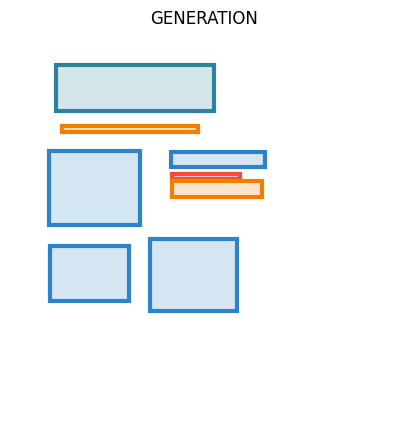

In [46]:
# code = torch.randn(1, conf.feature_size).to(device)

# infer through the model to get the generated hierarchy
# set maximal tree depth to conf.max_tree_depth
obj_arr = decoder.decode_structure(z=code, max_depth=conf.max_tree_depth)

obj_arr.get_arrbox()

# print(str(obj_arr))

# output the assembled box-shape
vis_utils.draw_partnet_objects([obj_arr],\
        object_names=['GENERATION'], \
        figsize=(5, 5), leafs_only=True, sem_colors_filename='./part_colors_magazine.txt')

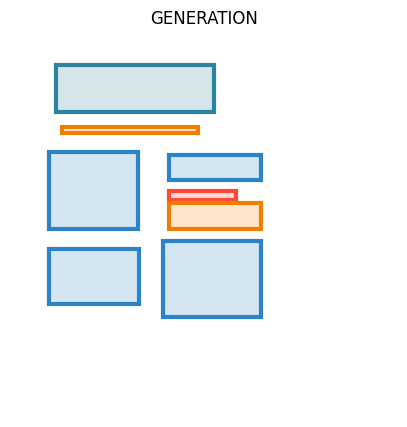

In [47]:
test_obj = obj_arr
arr_layout(test_obj.root)
arr_layout(test_obj.root)
test_obj.get_arrbox()

# output the assembled box-shape
vis_utils.draw_partnet_objects([test_obj],\
        object_names=['GENERATION'], \
        figsize=(5, 5), leafs_only=True, sem_colors_filename='./part_colors_magazine.txt')